In [ ]:
import pandas as pd
import numpy as np
import mip as mp #availalbe at https://github.com/ieshaw/Dynamic_Manning
from numpy.random import choice
import math
from matching import Player
from matching.games import HospitalResident
import random
from random import shuffle 
from random import randint

In [ ]:
#Use this to read data from csvs for mip packaage.  Format is available at https://github.com/ieshaw/Dynamic_Manning
seeker_df = pd.read_csv('S.csv', header=0, index_col=0)
seeker_df.index = seeker_df.index.map(str)
owner_df = pd.read_csv('O.csv', header=0, index_col=0)
owner_df.index = owner_df.index.map(str)
available_df = pd.read_csv('A.csv', header=0, index_col=0)
available_df.index = available_df.index.map(str)
placeHDict= {}


In [ ]:
#Use this to create randomized UNWEIGHTED datasets instead of importing csvs

num_seekers = int(input("How many seekers? "))
num_positions  = int(input("How many positions? "))
seeker_dict = {}
available_dict = {}

for seeker in range(1,num_seekers+1):
    temp_comlist = [i for i in range(1, num_positions+1)]
    shuffle(temp_comlist)
    seeker_dict["s_"+str(seeker)]= (temp_comlist)  
seeker_df=pd.DataFrame.from_dict(seeker_dict)
job_dict = {}
for j in range(num_positions):
    job_dict[j]="o_"+str(j+1)
seeker_df.rename(index=job_dict, inplace=True)    

owner_dict={}
for position in range(1,num_positions+1):
    temp_seeklist = [i for i in range(1, num_seekers+1)]
    shuffle(temp_seeklist)
    owner_dict["o_"+str(position)]= (temp_seeklist)
    available_dict["o_"+str(position)]= 1
owner_df = pd.DataFrame.from_dict(owner_dict)
seek_dict = {}
for j in range(num_seekers):
    seek_dict[j]="s_"+str(j+1)
owner_df.rename(index=seek_dict, inplace=True)

available_df = pd.DataFrame.from_dict(available_dict, orient='index')
placeHDict = {}


In [ ]:
#Use this to create randomized WEIGHTED datasets instead
def createRandomSets(prefix, numPositions):
    def normalize(probs):
        prob_factor = 1 / sum(probs)
        return [prob_factor * p for p in probs]

    job_list = []
    probability_distribution = []
    for x in range(numPositions):
        job_list.append(prefix+str(x+1))
        probability_distribution.append(math.pow(.8,x))

    probability_distribution = normalize(probability_distribution)
    list_of_candidates= job_list
    number_of_items_to_pick = numPositions

    draw = choice(job_list, number_of_items_to_pick, p=probability_distribution, replace=False)
    return(draw)

def createWeightedRandomSDF(num_p):
    final_dict = {}
    colnameList = []
    rowRefDict = {}
    for pos in range(1,num_p+1):
        final_dict["s_"+str(pos)]= createRandomSets("",num_p)
        rowRefDict[pos-1]="o_"+str(pos)
    posDF = pd.DataFrame.from_dict(final_dict)
    posDF.rename(index=rowRefDict, inplace=True)
    posDF = posDF.apply(pd.to_numeric)
    return(posDF)

def createWeightedRandomODF(num_p):
    final_dict = {}
    colnameList = []
    available_dict = {}
    rowRefDict = {}
    for pos in range(1,num_p+1):
        final_dict["o_"+str(pos)]= createRandomSets("",num_p)
        rowRefDict[pos-1]="s_"+str(pos)
        available_dict["o_"+str(pos)]=1
    posDF = pd.DataFrame.from_dict(final_dict)
    posDF.rename(index=rowRefDict, inplace=True)
    posDF = posDF.apply(pd.to_numeric)
    available_df = pd.DataFrame.from_dict(available_dict, orient='index')
    return(posDF, available_df)


p = int(input("Number of positions?"))
seeker_df  = createWeightedRandomSDF(p)
owner_df, available_df = createWeightedRandomODF(p)
placeHDict = {}


In [ ]:
#Metrics to be used later for comparison

def prefMetrics(owner_df, seeker_df, result_df):
    metricDict = {}
    
    seekers= list(result_df.columns.values)
    owners = list(result_df.index.values)
    s = {}
    o = {}
    for seeker in seekers:
        owner = (result_df[result_df[seeker]==1].index)[0]
        s[seeker]=owner
        o[owner]=seeker   

    ownerRank = {}
    seekerRank = {}
    
    for key in o.keys():
        ownerRank[key] = owner_df.at[o[key],key]
    for key in s.keys():
        seekerRank[key] = seeker_df.at[s[key],key]     
    return ownerRank, seekerRank

In [ ]:
#Run MIP-based matching, Write output to file, and print matrix. Inputs come from one of previous two cells
x = mp.mip(seeker_df, owner_df, available_df, placeHDict)
x.to_csv('opt.csv')
print(x)
o, s = prefMetrics(owner_df, seeker_df, x)
aveo = sum(o.values())/len(o.keys())
aves = sum(s.values())/len(s.keys())
ave = aveo+aves


In [ ]:
#Run random matching
def randomMatch(seeker_df, owner_df):
    x = pd.DataFrame(0, index=list(owner_df.columns.values), columns=list(seeker_df.columns.values))
    rList = list(range(len(seeker_df.columns)))
    random.seed()
    shuffle(rList)
    rT = 0
    for r in rList:
        x.iloc[rT,r]=1
        rT+=1
    return x



p = int(input("Number of positions?"))
num_iterations = int(input("How many iterations?"))

seeker_df  = createWeightedRandomSDF(p)
owner_df, available_df = createWeightedRandomODF(p)
placeHDict = {}
ranDict = {}


for timeThrough in range(num_iterations):
    
    seeker_dict = {}
    available_dict = {}

    seeker_df  = createWeightedRandomSDF(p)
    xyy = list(seeker_df.columns.values.tolist())
    random.shuffle(xyy)
    seeker_df = seeker_df[xyy]
    owner_df, available_df = createWeightedRandomODF(p)
    placeHDict = {}

    oldX = randomMatch(seeker_df, owner_df)
    o, s = prefMetrics(owner_df, seeker_df, oldX)
    oldaveo = sum(o.values())/len(o.keys())
    oldaves = sum(s.values())/len(s.keys())   
    oldave = oldaveo + oldaves

    for rep in range(100):
        newX = randomMatch(seeker_df, owner_df)
        o, s = prefMetrics(owner_df, seeker_df, newX)
        newaveo = sum(o.values())/len(o.keys())
        newaves = sum(s.values())/len(s.keys())  
        newave = newaveo + newaves
        if(newave <= oldave):
            oldX=newX
            oldaveo = newaveo
            oldaves = newaves
            oldave = newave
        
    oran, sran = prefMetrics(owner_df, seeker_df, oldX)
    ranaveo = sum(oran.values())/len(oran.keys())
    ranaves = sum(sran.values())/len(sran.keys())


    ranDict[timeThrough]= [ranaveo, ranaves, oran, sran]

In [ ]:
def parseRAvgPosition(ranDict):
    byownerran = {}
    byseekerran = {}
    for key1 in ranDict.keys():
        for key2 in ranDict[key1][2].keys():
            if key2 in byownerran.keys():
                byownerran[key2].append(ranDict[key1][2][key2])
            else:
                byownerran[key2]=[ranDict[key1][2][key2]]
                
        for key2 in ranDict[key1][3].keys():
            if key2 in byseekerran.keys():
                byseekerran[key2].append(ranDict[key1][3][key2])
            else:
                byseekerran[key2]=[ranDict[key1][3][key2]]                
                
    return byownerran, byseekerran        
                

In [ ]:
orand, srand = parseRAvgPosition(ranDict)
lastDF = pd.DataFrame.from_dict(srand)
lastDF = lastDF.reindex(sorted(lastDF.columns), axis=1)
lastDF.to_excel('srand.xls')

In [ ]:
#Use matching.py for Gale Shapley
seeker_prefs = {}
dd= seeker_df.to_dict()
for seekerKey in dd.keys():
    seeker_prefs[seekerKey]=[]
    for db in range(1,len(dd[seekerKey].keys())+1):
        seeker_prefs[seekerKey].append(list(dd[seekerKey].keys())[list(dd[seekerKey].values()).index(db)])

owner_prefs = {}
dd= owner_df.to_dict()
for ownerKey in dd.keys():
    owner_prefs[ownerKey]=[]
    for db in range(1,len(dd[ownerKey].keys())+1):
        owner_prefs[ownerKey].append(list(dd[ownerKey].keys())[list(dd[ownerKey].values()).index(db)])        

capacities = {own: 1 for own in owner_prefs}
        
game = HospitalResident.create_from_dictionaries(seeker_prefs, owner_prefs, capacities)        

daaDict= game.solve()
daaDF = pd.DataFrame(0, index=list(owner_df.columns.values), columns=list(seeker_df.columns.values))
for key in daaDict.keys():
    daaDF.at[str(key), str(daaDict[key][0])]=1
    
o, s = prefMetrics(owner_df, seeker_df, daaDF)
o = dict((k,int(v)) for k,v in o.items())
s = dict((k,int(v)) for k,v in s.items())
aveo = sum(o.values())/len(o.keys())
aves = sum(s.values())/len(s.keys())
ave = aveo+aves
print(daaDF)
print(aveo, aves, ave)    


In [ ]:
#MASTER- GATHER A BUNCH OF RESULTS
import pandas as pd
import numpy as np
import mip as mp
from numpy.random import choice
import math
from matching import Player
from matching.games import HospitalResident
import random
from random import shuffle
from random import randint

def prefMetrics(owner_df, seeker_df, result_df):
    metricDict = {}
    seekers= list(result_df.columns.values)
    owners = list(result_df.index.values)
    s = {}
    o = {}
    for seeker in seekers:
        owner = (result_df[result_df[seeker]==1].index)[0]
        s[seeker]=owner
        o[owner]=seeker   
    ownerRank = {}
    seekerRank = {}
    for key in o.keys():
        ownerRank[key] = owner_df.at[o[key],key]
    for key in s.keys():
        seekerRank[key] = seeker_df.at[s[key],key]
    return ownerRank, seekerRank


def createRandomSets(prefix, numPositions):
    def normalize(probs):
        prob_factor = 1 / sum(probs)
        return [prob_factor * p for p in probs]

    job_list = []
    probability_distribution = []
    for x in range(numPositions):
        job_list.append(prefix+str(x+1))
        probability_distribution.append(math.pow(.8,x))

    probability_distribution = normalize(probability_distribution)
    list_of_candidates= job_list
    number_of_items_to_pick = numPositions

    draw = choice(job_list, number_of_items_to_pick, p=probability_distribution, replace=False)
    return(draw)

def createWeightedRandomSDF(num_p):
    final_dict = {}
    colnameList = []
    rowRefDict = {}
    for pos in range(1,num_p+1):
        final_dict["s_"+str(pos)]= createRandomSets("",num_p)
        rowRefDict[pos-1]="o_"+str(pos)
    posDF = pd.DataFrame.from_dict(final_dict)
    posDF.rename(index=rowRefDict, inplace=True)
    posDF = posDF.apply(pd.to_numeric)
    return(posDF)

def createWeightedRandomODF(num_p):
    final_dict = {}
    colnameList = []
    available_dict = {}
    rowRefDict = {}
    for pos in range(1,num_p+1):
        final_dict["o_"+str(pos)]= createRandomSets("",num_p)
        rowRefDict[pos-1]="s_"+str(pos)
        available_dict["o_"+str(pos)]=1
    posDF = pd.DataFrame.from_dict(final_dict)
    posDF.rename(index=rowRefDict, inplace=True)
    posDF = posDF.apply(pd.to_numeric)
    available_df = pd.DataFrame.from_dict(available_dict, orient='index')
    return(posDF, available_df)


p = int(input("Number of positions?"))
num_iterations = int(input("How many iterations?"))

seeker_df  = createWeightedRandomSDF(p)
owner_df, available_df = createWeightedRandomODF(p)
placeHDict = {}

totalDict = {}


for timeThrough in range(num_iterations):
    
    seeker_dict = {}
    available_dict = {}

    seeker_df  = createWeightedRandomSDF(p)
    xyy = list(seeker_df.columns.values.tolist())
    random.shuffle(xyy)
    seeker_df = seeker_df[xyy]
    
    
    
    owner_df, available_df = createWeightedRandomODF(p)
    placeHDict = {}


    x = mp.mip(seeker_df, owner_df, available_df, placeHDict)
    omip, smip = prefMetrics(owner_df, seeker_df, x)
    mipaveo = sum(omip.values())/len(omip.keys())
    mipaves = sum(smip.values())/len(smip.keys())




    seeker_prefs = {}
    dd= seeker_df.to_dict()
    
    
    for seekerKey in dd.keys():
        seeker_prefs[seekerKey]=[]
        for db in range(1,len(dd[seekerKey].keys())+1):
            seeker_prefs[seekerKey].append(list(dd[seekerKey].keys())[list(dd[seekerKey].values()).index(db)])

    owner_prefs = {}
    dd= owner_df.to_dict()
    for ownerKey in dd.keys():
        owner_prefs[ownerKey]=[]
        for db in range(1,len(dd[ownerKey].keys())+1):
            owner_prefs[ownerKey].append(list(dd[ownerKey].keys())[list(dd[ownerKey].values()).index(db)])        

    capacities = {own: 1 for own in owner_prefs}
    


    game = HospitalResident.create_from_dictionaries(seeker_prefs, owner_prefs, capacities)        

    daaDict= game.solve()
    daaDF = pd.DataFrame(0, index=list(owner_df.columns.values), columns=list(seeker_df.columns.values))
    for key in daaDict.keys():
        daaDF.at[str(key), str(daaDict[key][0])]=1

    omm, smm = prefMetrics(owner_df, seeker_df, daaDF)
    mmaveo = sum(omm.values())/len(omm.keys())
    mmaves = sum(smm.values())/len(smm.keys())


    totalDict[timeThrough]= [mipaveo, mmaveo, mipaves, mmaves, omip, smip, omm, smm]





In [ ]:
td = pd.DataFrame.from_dict(totalDict)
td.rename(index={0:'MIP_AveOwner',1:'MM_AveOwner',2:'MIP_AveSeeker', 3:'MM_AveSeeker'}, inplace=True)

In [ ]:
def parseAvgPosition(totalDict):
    byownermip = {}
    byseekermip = {}
    byownermm = {}
    byseekermm = {}
    for key1 in totalDict.keys():
        for key2 in totalDict[key1][4].keys():
            if key2 in byownermip.keys():
                byownermip[key2].append(totalDict[key1][4][key2])
            else:
                byownermip[key2]=[totalDict[key1][4][key2]]

        for key2 in totalDict[key1][5].keys():
            if key2 in byseekermip.keys():
                byseekermip[key2].append(totalDict[key1][5][key2])
            else:
                byseekermip[key2]=[totalDict[key1][5][key2]]

        for key2 in totalDict[key1][6].keys():
            if key2 in byownermm.keys():
                byownermm[key2].append(totalDict[key1][6][key2])
            else:
                byownermm[key2]=[totalDict[key1][6][key2]]
                
        for key2 in totalDict[key1][7].keys():
            if key2 in byseekermm.keys():
                byseekermm[key2].append(totalDict[key1][7][key2])
            else:
                byseekermm[key2]=[totalDict[key1][7][key2]]
    return byownermip, byseekermip, byownermm, byseekermm        
                
        

In [ ]:
onavy, snavy, odaa, sdaa = parseAvgPosition(totalDict)

In [ ]:
lastDF = pd.DataFrame.from_dict(sdaa)
lastDF = lastDF.reindex(sorted(lastDF.columns), axis=1)
lastDF.to_excel('sdaa3.xls')

In [ ]:
onavy, snavy, odaa, sdaa = parseAvgPosition(totalDict)
lastDF = pd.DataFrame.from_dict(sdaa)
lastDF = lastDF.reindex(sorted(lastDF.columns), axis=1)
lastDF.to_excel('sdaa3.xls')

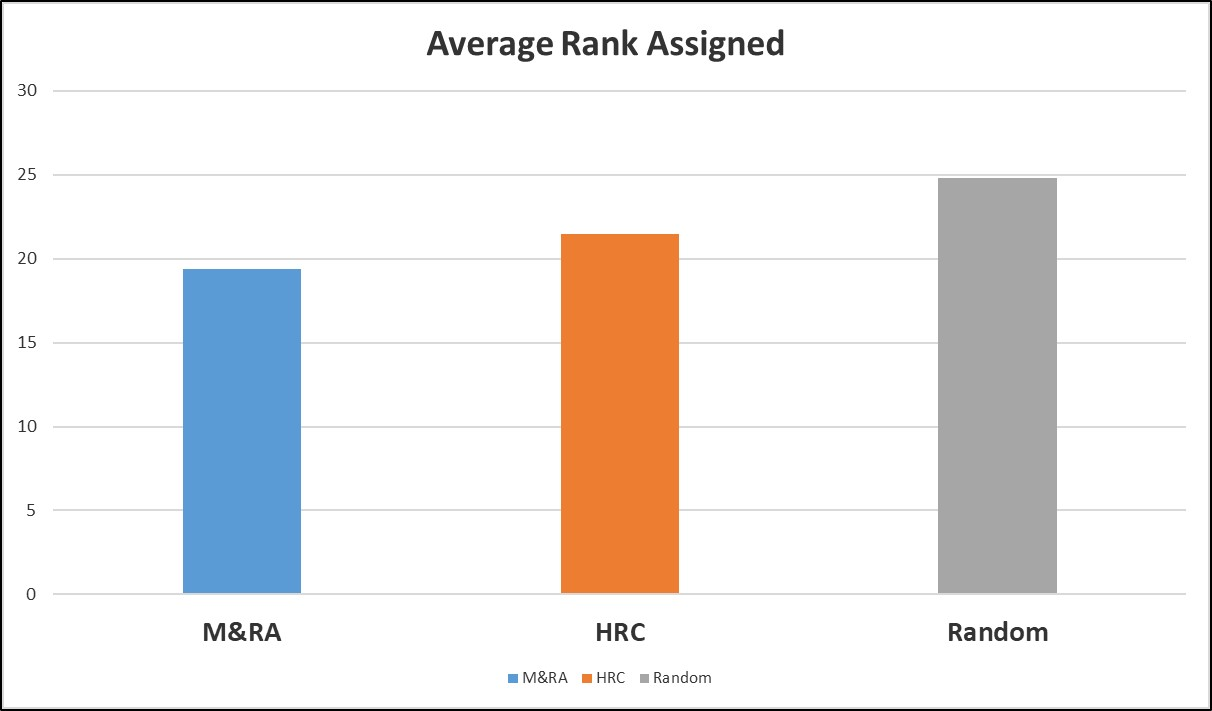

In [2]:
from IPython.display import Image
Image(filename='Picture2.jpg')
 

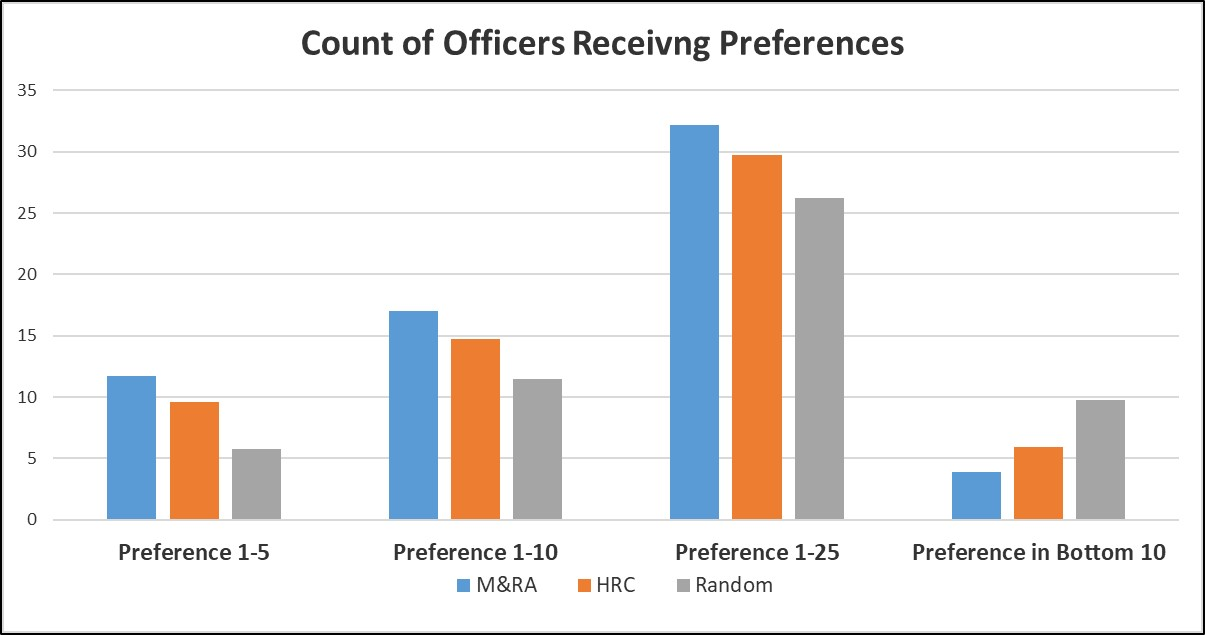

In [3]:
Image(filename='Picture1.jpg')

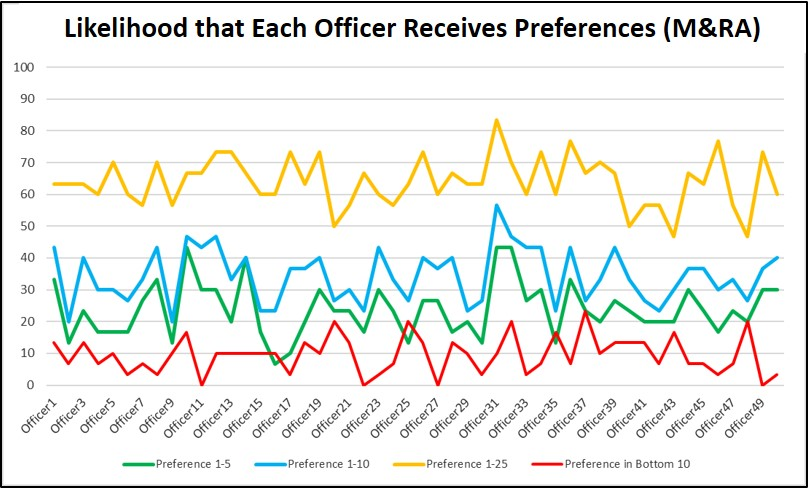

In [4]:
Image(filename='Picture3.jpg')

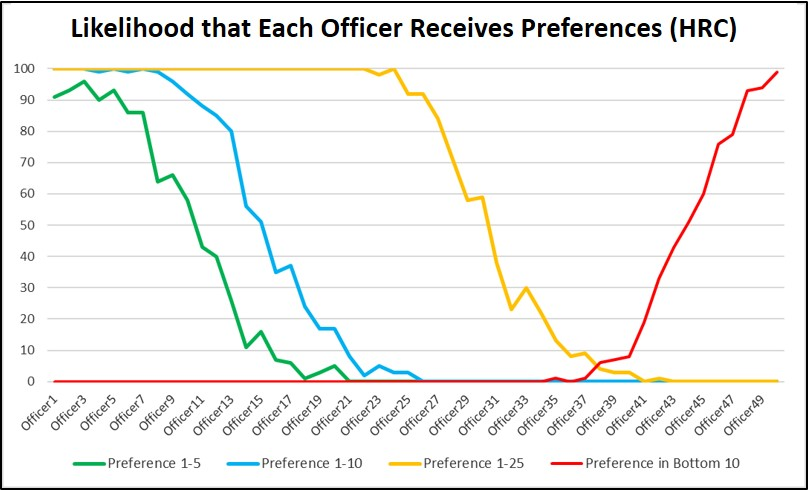

In [5]:
Image(filename='Picture4.jpg')